'''
Author: LIU X. xnd_liu@zju.edu.cn

Date: 2023-01-12 10:07:16

Description: For 2023 thesis use only.
'''


# Log

## 20230422
开始数值测试. 考虑对照文献设置信号长度和稀疏度, 以及噪声水平.
## 20230421
可以从ROC曲线下面积, F1-score(准确率和召回率的调和平均), 误差来衡量模型.
## 20230405
写完IRLSPKS. 算法性能比较可以从时间、先验贡献、RIP、重建误差、准确率和召回率、广义准确率和召回率(s-稀疏化后)等, 待补充.
## 20230404
把所有向量维数统一为`n`,之后可能的时间序列长度记为`N`.
## 20230402
大改代码. 把算法统一到各自的功能中,去掉多余的参数,例如先知信号等.将停机法则统一为相对更新率收敛至`eps=1e-6`.由于要比较迭代次数,可以设置可选输出`returnIter=True`.
题目含有'Exec!'的为直接可执行代码区域,注意绕开.
## 20230401
建议不要过度封装. 每个算法尽量展开写出.另外不要过度输出,可以只输出信号估计,而误差等可以不输出,而是改为在别的地方重新计算.|尝试加入haltingRule=('rIterErr',eps), 但不会以这种封装的方式, 而是针对个别算法.|以后要测试算法性能,考虑收敛时(因此要用'rIterErr'停机判定)取得的误差最小值,以及达到收敛需要的迭代次数.总的来看,'rIterErr'可能是比'rSampErr'更好的停机判据.
## 20230331
mod-(reg)-BPDN可以转化为一个二次规划问题, 用qp()解决.
`cvxopt.solvers.qp()`
(20230407) 可以进一步转化为线性规划, 用lp()解决.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cvxopt


In [2]:
import pickle

# Variable saving.


def pickleSave(var, filename='.pickle'):
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(var, f)
    print('PickleSave Succeeded.')
    return

# Variable loading.


def pickleLoad(filename):
    """
    Make sure it's assigned to a variable.
    """
    if '.pickle' not in filename:
        filename = filename + '.pickle'
    with open(filename, 'rb') as f:
        cache = pickle.load(f)
    print("PickleLoad Succeeded. Make sure it's assigned to a variable.")
    return cache


# 1 预备函数
## 1.1 随机采样阵生成

In [3]:
# 随机采样阵生成
def randSampMat(m, n):
    """
    Return m*n sampling matrix.
    Use type `np.float32`.
    """
    # 用高斯分布抽样, 列单位化.
    A = np.random.randn(m, n).astype(np.float32)
    for j in range(A.shape[1]):
        A[:, j] = A[:, j] / np.sqrt(A[:, j].dot(A[:, j]))
    return A


## 1.2 共轭梯度法
(Iterative) Conjugate gradient method.

In [4]:
def conjGrad(A, b, maxIter=-1, x="0", eps=1e-6, showChangeRate=False):
    """
    迭代的共轭梯度法. 要求A实正定对称.
    `x`:初始点.
    收敛相对误差|Δx[t]|/|x[t-1]|被`eps`控制.
    方法优点: 迭代至多进行k=len(b)次. A事先计算出,控制迭代次数,则复杂度O(k^2).
    不吝啬迭代则O(k^3).
    """
    k = A.shape[0]  # 行/列数。
    if maxIter == -1:
        maxIter = k
    if x == '0':
        x = np.zeros(k)
    r = b - np.dot(A, x)
    p = r
    r2old = r.dot(r)
    for i in range(maxIter):
        Ap = A.dot(p)
        alpha = r2old / (p.dot(Ap))
        xOld = x
        x = x + alpha * p
        r = r - alpha * Ap
        r2new = r.dot(r)
        changeRate = np.sqrt((x-xOld).dot(x-xOld)/(eps**2 + x.dot(x)))
        # 相对迭代误差(改进率).
        if showChangeRate:
            print('Iter', i, ':', changeRate)
        if changeRate < eps:
            break
        p = r + (r2new/r2old)*p
        r2old = r2new
    return x


## 1.3 限制等距常数估计

In [33]:
# RIP测试.
class RIPTest:
    def __init__(self, A, s):
        """
        Return possible delta_s given matrix `A` and sparsity `s`.

        Contain 3 methods: \n
            `RIPTest(A,s).monteCarlo(nVec,show)`: Monte Carlo method; \n
            `RIPTest(A,s).singularValue()`: singularValue method. \n
            `RIPTest(A,s).mixedMethod()`: Recommended! A mixed method of MC and SingVal.
        """
        self.A = A
        self.s = s

    # Monte-Carlo method.

    def monteCarlo(self, nVec=1e5, show=True):  # 这是一个对象方法.
        """
        Return possible delta_s given matrix `A` and sparsity `s`. \n
        `nVec`: Number of vectors to test. \n
        `show`: Whether to draw the distribution of amplifications. \n
        Running time: \n
            O(nVec=10000,n=10000,m=400)~70sec; \n
            O(nVec=5000,n=5000,m=200)~10sec; \n
            O(nVec=100000,n=200,m=50)~3sec.
        """
        n = self.A.shape[1]
        nVec = int(nVec)  # 转化形如`1e5`的输入.
        V = np.zeros((n, nVec), order='F', dtype=np.float32)  # 由多个s-稀疏的列向量组成.
        Supps = np.array(
            [np.random.choice(range(n), self.s, replace=False) for i in range(nVec)])
        # 随机抽取支集, 存为每一行.
        Entries = np.array(
            [np.random.randn(self.s).astype(np.float32) for i in range(nVec)])
        # 随机赋予支集项的值, 存为每一行. 未正规化.
        for j in range(nVec):
            # supp = Supps[j]
            # entries = Entries[j]
            V[Supps[j], j] = Entries[j]/np.linalg.norm(Entries[j])
        V = np.dot(self.A, V)
        # 象.
        Amplifications = np.array(
            list(map(lambda v: np.linalg.norm(v), np.transpose(V))))
        ampMax = np.max(Amplifications)
        delta1 = ampMax-1
        ampMin = np.min(Amplifications)
        delta2 = 1-ampMin
        delta = max(delta1, delta2)

        if show == True:
            # 用Gaussian近似检测delta估计是否超出3-sigma,若是,则认为delta即使再估计也不会显著增加,基本准确.
            var = np.var(Amplifications)
            mean = np.mean(Amplifications)
            threeSigma = 3*np.sqrt(var)
            ThreeSigmaPoints = [mean - threeSigma, mean + threeSigma]
            Xnorm = np.linspace(ThreeSigmaPoints[0], ThreeSigmaPoints[1], 100)
            Ynorm = stats.norm.pdf((Xnorm-mean)/np.sqrt(var))/np.sqrt(var)

            plt.hist(Amplifications, bins=100,
                     density=True, label='Amplifications')
            plt.plot(Xnorm, Ynorm, 'r:', label='Gaussian Reference')
            plt.axvline(
                ThreeSigmaPoints[0], linestyle='-.', color='g', label='-3 sigma')
            plt.axvline(
                ThreeSigmaPoints[1], linestyle='--', color='m', label='+3 sigma')
            plt.xlabel('Amp.')
            plt.ylabel('Density')
            plt.legend()
            plt.show()
            print("3-sigma points: [1 - {:}, 1 + {:}]".format(1 -
                  ThreeSigmaPoints[0], ThreeSigmaPoints[1]-1))

            if delta == delta1:
                side = 'Right'
            else:
                side = 'Left'
            print("Side:", side)
        return delta

    # SingularValue method.

    def singularValue(self, SAFECODE, showSingularValues=True, mode='memory-saving'):
        """
        有内存泄漏危险, 勿用! \n
        确认使用时输入参数`SAFECODE=CONFIRM`. \n
        Return delta_s. \n
        `showSingularValues`: Whether to show the two max&min singularValues of all submatrices. \n
        Running time: \n
            `mode='memory-saving'`: O(n=200,m=20,s=3)~30sec; O(n=2000,m=20,s=2)~39sec; O(n=2000,m=20,s=3)~ >5min. \n
            `mode='fast'`: O(n=200,m=20,s=3)~23sec; O(n=2000,m=20,s=2)~27sec; O(n=2000,m=20,s=3)~ >2min(MemoryError). \n        
        建议: \n
            1, 采用分布式计算, 因为耗时关于s指数级增长; \n
            2, 改用Monte-Carlo方法, 其估计概率已足够大; \n
            3, `fast`模式对于稍大矩阵几乎不能用, 基本上会报错`MemoryError`.
        """
        if SAFECODE != 'CONFIRM':
            print('Not safe!')
            return

        from itertools import combinations as cb

        n = self.A.shape[1]
        # 以时间换空间: 使用s个指针Pointers, 列举指针组合.
        if mode == 'memory-saving':
            PtrCombinations = cb(range(n), self.s)
            maxSv, minSv = 1, 1
            for ptr in PtrCombinations:
                ptr = list(ptr)
                Svs = np.sqrt(np.linalg.eigvals(
                    self.A[:, ptr].T.dot(self.A[:, ptr])))
                # `Svs` for 'Singular Values'.
                # Only accept float32+ type.
                maxSv = max(np.max(Svs), maxSv)
                minSv = min(np.min(Svs), minSv)
        # 以空间换时间.
        elif mode == 'fast':
            Submatrices = np.array(list(cb(self.A.transpose(), self.s)))
            Svs = np.sqrt(np.linalg.eigvals(Submatrices.T.dot(Submatrices)))

            maxSv = max(Svs)
            minSv = min(Svs)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues == True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta

    # A mixed version.

    def mixedMethod(self, times=10000, showSingularValues=True):
        """
        A better and safe mixed version of Monte-Carlo & SingularValue.
        """
        n = self.A.shape[1]
        maxSv, minSv = 1, 1
        for t in range(times):
            comb = np.random.choice(range(n), self.s, replace=False)
            submatrix = self.A[:, comb].astype(np.float32)
            Svs = np.linalg.eigvals(np.dot(submatrix.transpose(), submatrix))
            # `Svs` for 'Singular Values'.
            # Only accept float32+ type.
            maxSv = max(np.sqrt(np.max(Svs)), maxSv)
            minSv = min(np.sqrt(np.min(Svs)), minSv)

        delta = max(maxSv - 1, 1 - minSv)
        if showSingularValues == True:
            print('Max singular value:', maxSv)
            print('Min singular value:', minSv)
        return delta


## 1.4 硬阈值函数

In [6]:
# 硬阈值函数
def hardThreshold(x, s, T0=[]):
    """
    Return x with its largest s-k entries and k entries indexed in T0, the rest set to 0.
    """
    n = len(x)
    k = len(T0)
    comparingVec = x.copy()
    comparingVec[T0] = 0  # 去掉支集项以寻找剩余元素的s-k个最大值.
    delta = np.abs(comparingVec).argsort()[:-(s-k+1):-1]  # 返回s-k个绝对最大值的索引.
    supp = np.append(T0, delta).astype('int64')
    new = np.zeros(n)
    new[supp] = x[supp]

    return new


## 1.5 取支集

In [7]:
def getSupp(x: np.ndarray, s: int = -1):
    """
    Return supp(x_s) corresponding to from Largest to Smallest. \n
    If `s` left default, -1, then s=sum(x!=0).
    """
    if s == -1:
        s = sum(1 - np.isclose(x, 0))
    return np.abs(x).argsort()[:-s-1:-1]


## 1.6 测试信号生成

In [8]:
# Rademacher(1,-1,Prob=0.5) on support.
def randSparseSignal(n=2000, s=50, size=10000, returnSupports=False, allowLowerSparsity=False):
    """
    Generate `size` number of signals of dimension `n` and sparsity `s`.
    Aranged by columns.

    If `returnSupports`=`True` then also return Supports of Signals aranged by columns,
    repetitions might be included.
    """
    size = int(size)  # 转化形如`1e5`的输入.
    V = np.zeros((n, size), order='F', dtype=np.float32)
    Supps = np.array([np.random.choice(
        range(n), s, replace=allowLowerSparsity) for _ in range(size)])
    # 随机抽取支集, 存为每一行.
    Entries = np.array(
        [np.random.binomial(1, 0.5, s).astype(np.float32)*2-1 for _ in range(size)])
    # 随机赋予支集项的值, 存为每一行.
    for j in range(size):
        V[Supps[j], j] = Entries[j]
    if returnSupports == True:
        return dict(
            Signals=V,
            Supports=Supps.T
        )
    else:
        return V


## (Deprecated). errAnalyze()
可以作以后误差分析的参考.

In [9]:
# def errAnalyze(xReal,suppReal,x1,n,s,showPrecisionAndRecall,iterCount,eps,y,err,yNorm):
#     """
#     errAnalyze(xReal,suppReal,x1,n,s,showPrecisionAndRecall,iterCount,eps,y,err,yNorm)
#         -> dict(
#             estimate,iterCount,eps,y,errY,relativeErrY,confusion
#         )
#     """
#     if not (xReal is None):
#         if suppReal is None:
#             suppReal = np.argsort(np.abs(xReal))[:-(s+1):-1] #兼容compressible signal.

#         # Compute confusion matrix.
#         nPositive = np.sum(1-np.isclose(x1,0))
#         nTruePositive = np.sum(1-np.isclose(x1[suppReal],0))
#         nFalsePositive = nPositive - nTruePositive
#         nNegative = n - nPositive
#         nFalseNegative = np.sum(np.isclose(x1[suppReal],0))
#         nTrueNegative = nNegative - nFalseNegative

#         confusion = pd.DataFrame(np.array([
#             [nTruePositive,nTrueNegative],
#             [nFalsePositive,nFalseNegative]
#         ]), columns=['positive','negative'],index=['true','false'])
#         if showPrecisionAndRecall == True:
#             print('precision:',nTruePositive/(nTruePositive + nFalsePositive))
#             print('recall:',nTruePositive/(nTruePositive + nFalseNegative))

#     else:
#         confusion = None

#     return dict(
#         estimate=x1,
#         iterCount=iterCount,
#         eps=eps,
#         y=y,
#         errY=err,
#         relativeErrY=err/yNorm,
#         confusion=confusion
#     )


# 2 静态CS算法
## 2.1 IHT-PKS

In [10]:
# IHT-PKS
def IHTPKS(y: np.ndarray, Phi: np.ndarray, s: int, x0='0', T0=[], mu=1,
           maxIter: int = 100, eps=1e-6,
           returnIter=False,
           showIfMaxIter=False, showChangeRate=False):
    """
    `mu`:Learning rate. \n
    Return signal estimate. \n
    If `returnIter`, return tuple(signalEsti,iter).
    """
    n = Phi.shape[1]  # signal length.
    if x0 == '0':
        x0 = np.zeros(n)

    for t in range(maxIter):
        p = x0 + mu * Phi.T.dot(y - Phi.dot(x0))  # proxy.
        x1 = hardThreshold(p, s, T0)
        dx = x1-x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        else:
            x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.2 OMP-PKS

In [11]:
def OMPPKS(y, Phi: np.ndarray, x0='0', T0=[],
           maxIter: int = 100, eps=1e-6,
           returnIter=False,
           showIfMaxIter=False, showChangeRate=False):
    """
    Does not require sparsity 's'.
    """
    # Init.
    n = Phi.shape[1]
    if x0 == '0':
        x0 = np.zeros(n)
    supp = list(T0)  # PKS.

    # Iteration.
    for t in range(maxIter):
        p = Phi.T.dot(y - Phi.dot(x0))  # proxy.
        j = np.argmax(np.abs(p))
        if j not in supp:
            supp.append(j)
        x1 = np.zeros(n)
        # Use conjGrad to solve lstsq problem.
        # Note here the problem is |Phi.T.dot(Phi).dot(x)-Phi.T.dot(y)|->0.
        x1[supp] = conjGrad(Phi[:, supp].T.dot(
            Phi[:, supp]), Phi[:, supp].T.dot(y))

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        else:
            x0 = x1
    else:  # maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.3 CoSaMP-PKS

In [12]:
# CosampPKS
def CosampPKS(y: np.ndarray, Phi: np.ndarray, s: int, T0=[],
              conjGradIter=-1,
              maxIter: int = 100, eps=1e-6,
              returnIter=False,
              showIfMaxIter=False, showChangeRate=False):
    """
    Return signal estimate. \n
    If `returnIter`, return tuple(signalEsti,iter).

    If `conjGradIter` left default, -1, then it iterates enough times.
    """
    n = Phi.shape[1]  # signal length.
    T0 = list(T0)
    x0 = np.zeros(n)
    if len(T0) > 0:  # A priori.
        x0[T0] = conjGrad(Phi[:, T0].T.dot(Phi[:, T0]),
                          Phi[:, T0].T.dot(y), conjGradIter)
    r = y - Phi[:, T0].dot(x0[T0])  # 感知残差.
    K = s - len(T0)  # 剩余稀疏度.

    for t in range(maxIter):
        p = Phi.T.dot(r)  # proxy.
        Omega = getSupp(p, 2*K)  # 2K-supp of proxy.
        Tm = list(set(Omega) | set(getSupp(x0)))  # Supp merge.
        b = np.zeros(n)
        b[Tm] = conjGrad(Phi[:, Tm].T.dot(Phi[:, Tm]),
                         Phi[:, Tm].T.dot(y), conjGradIter)
        # Elaborative solution.
        A = b.copy()
        A[T0] = 0  # Auxiliary.
        x1 = np.zeros(n)
        supp = list(set(T0) | set(getSupp(A, K)))
        x1[supp] = b[supp]
        r = y - Phi.dot(x1)

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        else:
            x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.4 RWLS-Sl0-PKS

In [13]:
# RWLSSl0PKS.
def RWLSSl0PKS(y: np.ndarray, Phi: np.ndarray, T0=[],
               lamb=1e-4, sigmaMin=1e-8,
               conjGradIter=-1,
               maxIter: int = 100, eps=1e-6,
               returnIter=False,
               showIfMaxIter=False, showChangeRate=False):
    """
    `lamb`: Recommend (noise^2)*sqrt(1.5*log(n)). \n
    Return signal estimate. \n
    If `returnIter`, return tuple:(signalEsti,iter). \n
    If `conjGradIter` left default, -1, then it iterates enough times.
    """
    m, n = Phi.shape
    T0 = list(T0)
    x0 = np.zeros(n)
    K = int(m/np.log(n/m))  # Very rough Sparsity estimate.
    # Init.
    w = np.ones(n)  # We let w=inverse(w1,...,wn)
    w[T0] = 100
    # Weight by row.
    x0 = (w * Phi).T.dot(conjGrad(Phi.dot((w * Phi).T)+lamb*np.identity(m), y))
    # Cost:O((m^2*n^2)^3)=poly(m,n).

    for t in range(maxIter):
        sigma = max(sigmaMin, sorted(np.abs(x0))[-(K+1)])
        w = (sigma + np.abs(x0))**2
        w[T0] *= 100
        x1 = (w * Phi).T.dot(conjGrad(Phi.dot((w * Phi).T)+lamb*np.identity(m), y))

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.5 IRLS-PKS

In [14]:
# IRLSPKS.
def IRLSPKS(y: np.ndarray, Phi: np.ndarray, T0=[],
            p: int = 1, mu=1e-3, tau=1e-3,
            conjGradIter=-1,
            maxIter: int = 100, eps=1e-6,
            returnIter=False,
            showIfMaxIter=False, showChangeRate=False):
    """
    `p`: Norm number, in (0,1]. \n
    `mu`: Normalizing param. `sqrt(mu)/100`'s Minimum is `eps`. \n
    `tau`: Short for tau^(2-p) in the paper. Weighting param. \n
    Return signal estimate. \n
    If `returnIter`, return tuple:(signalEsti,iter). \n
    If `conjGradIter` left default, -1, then it iterates enough times.
    """
    n = Phi.shape[1]  # signal length.
    T0 = list(T0)
    x0 = np.zeros(n)
    # Init.
    q = np.ones(n)  # q=(q1,...,qn)
    q[T0] = tau
    # Q = np.diag(q)
    # Inverse weight matrix. Not used so as to accelerate.
    x0 = (q * Phi).T.dot(conjGrad(Phi.dot((q * Phi).T), y))  # Weight by row.
    # Cost:O((m^2*n^2)^3)=poly(m,N).

    for t in range(maxIter):
        q = np.abs(x0)**(2-p)
        q[T0] *= tau
        q += mu
        x1 = (q * Phi).T.dot(conjGrad(Phi.dot((q*Phi).T), y))
        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < np.sqrt(mu)/100:
            if mu <= eps:
                iter = t
                break
            else:
                mu /= 10
        x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.6 Modified-CS

In [15]:
# ModCS
def ModCS(y: np.ndarray, Phi: np.ndarray, T0=[],
          lamb=1e-1):
    """
    Return xEsti. \n
    `lamb`: s.t. Dantzig |Phi'@(y-Phi@x)| < `lamb`.
    """
    n = Phi.shape[1]
    T0 = list(T0)
    x = np.zeros(n)

    # Variables for LP:
    c = np.ones(2*n)
    c[T0] = 0
    c[n:][T0] = 0
    c = cvxopt.matrix(c, (2*n, 1), 'd')
    F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
    d = Phi.T.dot(y)
    G = np.block([[-np.identity(2*n)],
                  [F],
                  [-F]])
    G = cvxopt.matrix(G, (4*n, 2*n), 'd')
    h = np.block([np.zeros(2*n),
                  d + lamb*np.ones(n),
                  -d + lamb*np.ones(n)])
    h = cvxopt.matrix(h, (4*n, 1), 'd')
    xsol = cvxopt.solvers.lp(c, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x = xsol

    return x


## 2.7 Weighted-l1

In [16]:
# wl1
def weightedl1(y: np.ndarray, Phi: np.ndarray, T0=[],
               w=1e-2, lamb=1e-1):
    """
    Return xEsti. \n
    `lamb`: s.t. Dantzig |Phi'@(y-Phi@x)| < `lamb`. \n
    `w`: Weight for x[T0].
    """
    n = Phi.shape[1]
    T0 = list(T0)
    x = np.zeros(n)

    # Variables for LP:
    c = np.ones(2*n)
    c[T0] = 1e-2
    c[n:][T0] = 1e-2
    c = cvxopt.matrix(c, (2*n, 1), 'd')
    F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
    d = Phi.T.dot(y)
    G = np.block([[-np.identity(2*n)],
                  [F],
                  [-F]])
    G = cvxopt.matrix(G, (4*n, 2*n), 'd')
    h = np.block([np.zeros(2*n),
                  d + lamb*np.ones(n),
                  -d + lamb*np.ones(n)])
    h = cvxopt.matrix(h, (4*n, 1), 'd')
    xsol = cvxopt.solvers.lp(c, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x = xsol

    return x


## 2.8 Reweighted-l1

In [17]:
# rwl1
def reweightedl1(y: np.ndarray, Phi: np.ndarray, T0=[],
                 mu=1e-3, lamb=1e-1,
                 maxIter: int = 100, eps=1e-6,
                 returnIter=False,
                 showIfMaxIter=False, showChangeRate=False):
    """
    `lamb`: Dantzig boundary. \n
    `mu`: Regularizing param of weights. \n
    Return signal estimate. \n
    If `returnIter`, return tuple:(signalEsti,iter). \n
    """
    m, n = Phi.shape
    T0 = list(T0)
    x0 = np.zeros(n)
    # Init.
    w = np.ones(n)

    for t in range(maxIter):
        w = (np.abs(x0) + mu)**(-1)
        w[T0] *= 0.1

        # Variables for LP:
        c = np.append(w, w)
        c = cvxopt.matrix(c, (2*n, 1), 'd')
        F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
        d = Phi.T.dot(y)
        G = np.block([[-np.identity(2*n)],
                      [F],
                      [-F]])
        G = cvxopt.matrix(G, (4*n, 2*n), 'd')
        h = np.block([np.zeros(2*n),
                      d + lamb*np.ones(n),
                      -d + lamb*np.ones(n)])
        h = cvxopt.matrix(h, (4*n, 1), 'd')
        xsol = cvxopt.solvers.lp(c, G, h)
        xsol = np.array(xsol['x'])
        xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
        xsol = xsol[:, 0]
        x1 = xsol

        dx = x1 - x0
        changeRate = np.sqrt(dx.dot(dx) / (x1.dot(x1) + eps**2))
        if showChangeRate:
            print('Iter:', t, 'ChangeRate:', changeRate)  # Log.
        if changeRate < eps:
            iter = t
            break
        x0 = x1
    else:  # Reach maxIter.
        iter = maxIter-1
        if showIfMaxIter:
            print('Reach maxIter:', maxIter)

    if returnIter:
        return (x1, iter)
    else:
        return x1


## 2.9 Reg-mod-BPDN

In [18]:
# regModBPDN
def regModBPDN(y: np.ndarray, Phi: np.ndarray, T0=[],
               x0=None, gamma=1., lamb=1.):
    """
    Return xEsti. \n
    Params: \n
        min `gamma`*|x[T0^c]|(l1) + \n
            0.5|y-Phi@x|(l2)^2 + \n
            0.5*`lamb`*|x[T0]-`x0`[T0]|(l2)^2.
    """
    n = Phi.shape[1]
    T0 = list(T0)
    x = np.zeros(n)
    if x0 is None:  # Degenerate to mod-MPDN.
        x0 = np.zeros(n)
        lamb = 1e-12

    # Variables for Quadratic Program:
    posNeg = np.block([[np.identity(n), -np.identity(n)]])
    oneT0 = np.zeros(n)
    oneT0[T0] = 1
    diagT0 = np.diag(oneT0)
    P = posNeg.T @ (lamb * diagT0 + Phi.T @ Phi) @ posNeg
    P = cvxopt.matrix(P, (2*n, 2*n), 'd')
    oneT0c = np.ones(n)
    oneT0c[T0] = 0
    oneOneT0c = np.append(oneT0c, oneT0c)
    q = gamma * oneOneT0c - posNeg.T @ Phi.T @ y - lamb * posNeg.T @ diagT0 @ x0
    q = cvxopt.matrix(q, (2*n, 1), 'd')
    G = -np.identity(2*n)
    G = cvxopt.matrix(G, (2*n, 2*n), 'd')
    h = np.zeros(2*n)
    h = cvxopt.matrix(h, (2*n, 1), 'd')

    xsol = cvxopt.solvers.qp(P, q, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x = xsol

    return x


# 3 动态CS算法
## 3.1 LS-CS-residual

### 3.1.1 静态核 LS-CS-residual

In [19]:
# LSCSresidualStatic
def LSCSResidualStatic(y: np.ndarray, Phi: np.ndarray, T0=[],
                       lamb=1e-1, alpha=0.05, alphaDel=0.15,
                       conjGradIter=-1):
    """
    Return (xEsti, T_Esti).
    """
    m, n = Phi.shape
    T0 = list(T0)
    x0 = np.zeros(n)  # x_init
    x0[T0] = conjGrad(Phi[:, T0].T.dot(Phi[:, T0]), Phi[:, T0].T.dot(y))
    yRes = y - Phi.dot(x0)  # LS-residual y_res
    # Variables for LP:
    c = cvxopt.matrix(np.ones(2*n), (2*n, 1), 'd')
    F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
    dRes = Phi.T.dot(yRes)
    G = np.block([[-np.identity(2*n)],
                  [F],
                  [-F]])
    G = cvxopt.matrix(G, (4*n, 2*n), 'd')
    h = np.block([np.zeros(2*n),
                  dRes + lamb*np.ones(n),
                  -dRes + lamb*np.ones(n)])
    h = cvxopt.matrix(h, (4*n, 1), 'd')
    xsol = cvxopt.solvers.lp(c, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x0 += xsol  # x_CSres
    # Detect:
    Tdet = list(set(T0) | set(np.arange(n)[np.abs(x0) > alpha]))
    x0 = np.zeros(n)
    x0[Tdet] = conjGrad(Phi[:, Tdet].T.dot(
        Phi[:, Tdet]), Phi[:, Tdet].T.dot(y))
    # x_det
    # Delete:
    Tt = list(set(Tdet) - set(np.arange(n)[np.abs(x0) <= alphaDel]))
    x0 = np.zeros(n)  # x_final
    x0[Tt] = conjGrad(Phi[:, Tt].T.dot(Phi[:, Tt]), Phi[:, Tt].T.dot(y))

    return (x0, Tt)


### 3.1.2 动态 LS-CS
我们采取这样的策略: 对于第一个信号我们假设有足够的采样使得可以得到先知的信息. 因此下面的`Y[:,0]`是事实上的第二个信号采样. `x0`,`T0`为第一个信号的先知信息.

In [20]:
# LSCSresidual
def LSCSResidual(Y: np.ndarray, Phi: np.ndarray, x0: np.ndarray, T0=[],
                 lamb=1e-1, alpha=0.05, alphaDel=0.15,
                 conjGradIter=-1,
                 ):
    """
    Return signal sequence reconstruction for observed `Y`.
    """
    if T0 == []:
        T0 = list(getSupp(x0))
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    X = np.zeros((n, N))
    for t in range(N):
        X[:, t], T0 = LSCSResidualStatic(
            Y[:, t], Phi, T0, lamb, alpha, alphaDel, conjGradIter)
    print('LSCSresidual Succeeded.')
    return X


## 3.2 KF-CS-residual
### 3.2.1 静态核 KF-CS

In [21]:
# KFCSresidualStatic
def KFCSResidualStatic(y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
                       P0=None, sigma2Sys=0.01, sigma2=0.01, lamb=0.1,
                       alpha=0.05, alphaDel=0.15,
                       ):
    """
    Return (xEsti, P_Esti, T_Esti).
    """
    m, n = Phi.shape
    if x0 is None:
        x0 = np.zeros(n)
    if P0 is None:
        P0 = np.zeros((n, n))
    T0 = list(T0)
    Q = np.zeros((n, n))
    np.diag(Q)[T0] = sigma2Sys
    P10 = P0 + Q
    # P10[T0,T0] is non-zero
    K = np.zeros((n, m))
    K[T0, :] = P10[T0, T0] @ Phi[:, T0].T @ np.linalg.inv(
        Phi[:, T0] @ P10[T0, T0] @ Phi[:, T0].T + sigma2 * np.identity(m))
    # O(m^3)
    # K[T0,:] is non-zero.
    # P[T0,T0] is nonzero.
    P = np.zeros((n, n))
    P[T0, T0] = (np.identity(len(T0)) - K[T0, :] @ Phi[:, T0]) @ P10[T0, T0]
    x = np.zeros(n)
    x[T0] = (np.identity(len(T0)) - K[T0, :] @ Phi[:, T0]
             ) @ x0[T0] + K[T0, :] @ y  # x_init
    yRes = y - Phi[:, T0] @ x[T0]  # yRes

    # Variables for LP:
    c = cvxopt.matrix(np.ones(2*n), (2*n, 1), 'd')
    F = np.block([[Phi.T.dot(Phi), -Phi.T.dot(Phi)]])
    dRes = Phi.T.dot(yRes)
    G = np.block([[-np.identity(2*n)],
                  [F],
                  [-F]])
    G = cvxopt.matrix(G, (4*n, 2*n), 'd')
    h = np.block([np.zeros(2*n),
                  dRes + lamb*np.ones(n),
                  -dRes + lamb*np.ones(n)])
    h = cvxopt.matrix(h, (4*n, 1), 'd')
    xsol = cvxopt.solvers.lp(c, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x += xsol  # x_CSres

    # Detect:
    Tdet = list(set(T0) | set(np.arange(n)[np.abs(x) > alpha]))
    if set(Tdet) == set(T0):
        pass
    else:
        x = np.zeros(n)
        x[Tdet] = conjGrad(Phi[:, Tdet].T.dot(
            Phi[:, Tdet]), Phi[:, Tdet].T.dot(y))
        # x_det
    # Delete:
    Tt = list(set(Tdet) - set(np.arange(n)[np.abs(x) <= alphaDel]))
    if set(Tt) == set(T0):
        P1 = P0
    else:
        x = np.zeros(n)  # x_final
        x[Tt] = conjGrad(Phi[:, Tt].T.dot(Phi[:, Tt]), Phi[:, Tt].T.dot(y))
        P1 = np.zeros((n, n))
        P1[Tt, Tt] = sigma2 * np.linalg.inv(Phi[:, Tt].T @ Phi[:, Tt])
    return (x, P1, Tt)


### 3.2.2 动态 KF-CS

In [22]:
def KFCSResidual(Y: np.ndarray, Phi: np.ndarray, x0: np.ndarray,
                 T0=[],
                 P0=None, sigma2Sys=0.01, sigma2=0.01, lamb=0.1,
                 alpha=0.05, alphaDel=0.15,):
    """
    Return signal sequence reconstruction for observed `Y`.
    """
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    if T0 == []:
        T0 = list(getSupp(x0))
    if P0 is None:
        P0 = np.zeros((n, n))
        P0[T0, T0] = sigma2 * np.linalg.inv(Phi[:, T0].T @ Phi[:, T0])
    X = np.zeros((n, N))
    for t in range(N):
        x0, P0, T0 = KFCSResidualStatic(
            Y[:, t], Phi, x0, T0, P0, sigma2Sys, sigma2, lamb, alpha, alphaDel)
        X[:, t] = x0
    print('KFCSresidual Succeeded.')
    return X


## 3.3 Dynamic Reg-mod-BPDN
### 3.3.1 静态核 DRegModBPDN

In [23]:
def dynamicRegModBPDNStatic(
        y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
        gamma=1., lamb=1., alpha=0.1):
    '''
    return (xEsti, TEsti). \n
    `alpha`: Detection param.
    '''
    n = Phi.shape[1]
    x = regModBPDN(y, Phi, T0, x0, gamma, lamb)
    # Simple supp detection:
    Tt = np.arange(n)[np.abs(x) > alpha]

    return (x, Tt)


### 3.3.2 动态 DRegModBPDN

In [24]:
def dynamicRegModBPDN(
    Y: np.ndarray, Phi: np.ndarray, x0=None, T0=[],
    gamma=1., lamb=1., alpha=0.1
):
    '''
    Return signal sequence reconstruction for observed `Y`. \n
    `alpha`: Simple detection param.
    '''
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    if T0 == []:
        T0 = list(getSupp(x0))
    X = np.zeros((n, N))
    for t in range(N):
        x0, T0 = dynamicRegModBPDNStatic(
            Y[:, t], Phi, x0, T0, gamma, lamb, alpha)
        X[:, t] = x0
    print('DynamicRegModBPDN Succeeded.')
    return X


## 3.4 Mod-BPDN-residual
### 3.4.1 静态核 MBR
借用RegModBPDN, 将其中的reg项忽略即退化为ModBPDN.

In [25]:
def modBPDNResidualStatic(
        y: np.ndarray, Phi: np.ndarray, x0=None, T0=[], gamma=1.,
        alpha=0.1
):
    '''
    return (xEsti, TEsti). \n
    `alpha`: Simple detection threshold.
    '''
    n = Phi.shape[1]
    if x0 is None:
        x0 = np.zeros(n)
    yRes = y - Phi @ x0
    xRes = regModBPDN(yRes, Phi, T0, gamma)
    x = x0 + xRes
    # Simple detection:
    Tt = np.arange(n)[np.abs(x) > alpha]

    return (x, Tt)


### 3.4.2 动态 MBR

In [26]:
def modBPDNResidual(Y:np.ndarray, Phi:np.ndarray, x0=None,
                    T0=[], gamma=1., alpha=0.1):
    '''
    `alpha`: Detection param. \n 
    return signal sequence reconstruction from observed `Y`.
    '''
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    if T0 == []:
        T0 = list(getSupp(x0))
    X = np.zeros((n, N))
    for t in range(N):
        x0, T0 = modBPDNResidualStatic(
            Y[:, t], Phi, x0, T0, gamma, alpha)
        X[:, t] = x0
    print('ModBPDNResidual Succeeded.')
    return X
    

## 3.5 Streaming mod-wl1
### 3.5.1 静态核 StrModWl1

In [27]:
def streamingModWl1Static(y: np.ndarray, Phi: np.ndarray, x0=None,
                          gamma=1., eps=1e-6):
    '''
    return xEsti. \n
    `eps`: Avoid zero division.
    '''
    n = Phi.shape[1]
    if x0 is None:
        x0 = np.zeros(n)
    beta = n * (x0 @ x0)/((np.sum(np.abs(x0))+eps)**2)
    w = gamma / (beta * np.abs(x0) + 1)

    # Variables for QP:
    posNeg = np.block([[np.identity(n), -np.identity(n)]])
    P = 0.5 * posNeg.T @ Phi.T @ Phi @ posNeg
    P = cvxopt.matrix(P,(2*n,2*n),'d')
    q = posNeg.T @ (w - Phi.T @ y)
    q = cvxopt.matrix(q, (2*n, 1), 'd')
    G = -np.identity(2*n)
    G = cvxopt.matrix(G, (2*n, 2*n), 'd')
    h = np.zeros(2*n)
    h = cvxopt.matrix(h, (2*n, 1), 'd')
    xsol = cvxopt.solvers.qp(P, q, G, h)
    xsol = np.array(xsol['x'])
    xsol = xsol[:n]-xsol[n:]  # Note! This solution is 2-d.
    xsol = xsol[:, 0]
    x = xsol

    return x


### 3.5.2 动态 StrModWl1

In [28]:
def streamingModWl1(Y: np.ndarray, Phi: np.ndarray, x0=None,
                    gamma=1., eps=1e-6, **kwargs):
    '''
    `eps`: Avoid zero division. \n 
    return signal sequence reconstruction from observed `Y`.
    '''
    m, N = Y.shape  # Sequence length.
    assert m == Phi.shape[0]
    n = Phi.shape[1]
    # No need for T0.
    X = np.zeros((n, N))
    for t in range(N):
        x0 = streamingModWl1Static(
            Y[:, t], Phi, x0, gamma, eps)
        X[:, t] = x0
    print('StreamingModWl1 Succeeded.')
    return X


# 4(executable) 数值测试

## 4.1 Rademacher signals with Gaussian noise test
### 4.1.1 Static CS
Pickled.
之后可能会vary defferent sparsities.

In [100]:
# # Generate X of length 1000, spasity 50, size 300:
# np.random.seed(42)

# XX = randSparseSignal(n=1000, s=50, size=300, returnSupports=True)
# Means, Supps = XX['Signals'], XX['Supports']
# del XX
# # Corrupt with Gaussian noise N(0,0.2): (E|e|=0.1596)
# Noises = np.random.normal(0,0.2,(1000,300))
# X = Means + Noises
# del Means
# del Noises

# # Generate Phi of measurements 50 to 600, step=50, total 12:
# sampMats = []
# numsMeasurements = np.arange(start=50, stop=600+1, step=50)
# RIC_s = []
# RIC_3s = []
# for m in numsMeasurements:  # Total 12.
#     Phi = randSampMat(m, 1000)
#     sampMats.append(Phi)
#     # Estimate RIC for varying measurements:
#     RIC_s.append(RIPTest(Phi, 50).mixedMethod(1000))
#     RIC_3s.append(RIPTest(Phi, 3*50).mixedMethod(1000))

# RICMeasurementsChart = pd.DataFrame({'Measurements': numsMeasurements,
#                                      'RIC_s': RIC_s, 'RIC_3s': RIC_3s})

# # pickleSave sampMats, X, Supps, RICMeaurementsChart.
# pickleSave(sampMats, 'sampMats')
# pickleSave(X, 'X')
# pickleSave(Supps, 'Supps')
# pickleSave(RICMeasurementsChart, 'RICMeasurementsChart')

C:\Users\xndliu\AppData\Local\Temp\ipykernel_21764\3698915476.py:144: RuntimeWarning: invalid value encountered in sqrt
  minSv = min(np.sqrt(np.min(Svs)), minSv)


Max singular value: 2.086901
Min singular value: 5.6726876e-05
Max singular value: 2.830049
Min singular value: nan
Max singular value: 1.7557855
Min singular value: 0.23039576
Max singular value: 2.2782242
Min singular value: nan
Max singular value: 1.6233495
Min singular value: 0.37953752
Max singular value: 2.0759387
Min singular value: 0.00011125106
Max singular value: 1.5320915
Min singular value: 0.45634773
Max singular value: 1.907842
Min singular value: 0.106121294
Max singular value: 1.4905002
Min singular value: 0.51752913
Max singular value: 1.8270026
Min singular value: 0.20281774
Max singular value: 1.4398334
Min singular value: 0.55119365
Max singular value: 1.7513621
Min singular value: 0.2597054
Max singular value: 1.4238139
Min singular value: 0.59536594
Max singular value: 1.6939121
Min singular value: 0.31356913
Max singular value: 1.3927962
Min singular value: 0.61705446
Max singular value: 1.6415275
Min singular value: 0.3650419
Max singular value: 1.3584646
Min si

In [101]:
# pickleLoad:
sampMats = pickleLoad('sampMats')
RICMeasurementsChart = pickleLoad('RICMeasurementsChart')
X = pickleLoad('X')
Supps = pickleLoad('Supps')

numsMeasurements = np.array(RICMeasurementsChart)[:,0].astype(int)
RIC_s = np.array(RICMeasurementsChart)[:,1]
RIC_3s = np.array(RICMeasurementsChart)[:,2]

PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.
PickleLoad Succeeded. Make sure it's assigned to a variable.


RIC ~ Measurements figure.

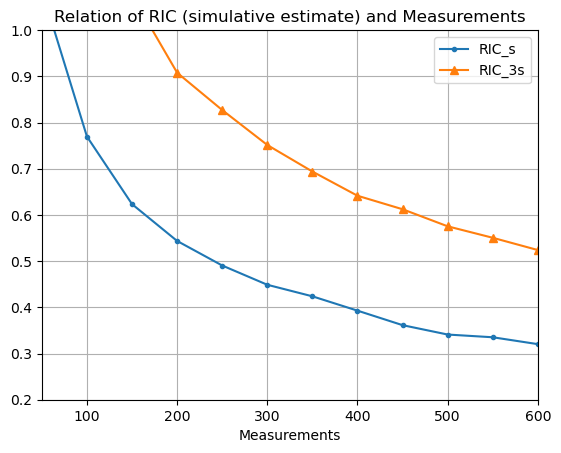

In [102]:
plt.plot(numsMeasurements, RIC_s, '.-', label='RIC_s')
plt.plot(numsMeasurements, RIC_3s, '^-', label='RIC_3s')
plt.ylim((0.2, 1.0))
plt.xlim((50, 600))
plt.xlabel('Measurements')
plt.title('Relation of RIC (simulative estimate) and Measurements')
plt.legend()
plt.grid()
plt.show()


#### 4.1.1.1 IHT-PKS
尝试加入time_tracker for respective `m`, `pR`.

In [104]:
# Reconstructions:
priorRatios = [0., 0.2, 0.4, 0.6, 0.8, 1.]  # Total 6.


def IHTPKS_simulate(X, sampMats, priorRatios, Supps, s=50):
    '''
    description: 
    return {XHat_pR}: \n
    `XHat_pR[i_class(0:5)]` w.r.t. a priorRatio; \n
    `XHat_pR[i_class][i_batch(0:11)]` w.r.t. a sampMatrix; \n
    `XHat_pR[i_class][i_batch][:,j]` j-th signal estimate.
    '''
    XHat_pR = []
    iClass = 0
    for pR in priorRatios:  # Different prior information.
        XHat_m = []
        iBatch = 0
        for Phi in sampMats:  # Different measurements.
            Y = Phi @ X  # Observations.
            XHat = np.zeros(X.shape)
            for j in range(X.shape[1]):  # Different signals.
                y = Y[:, j]
                suppReal = Supps[:, j]
                T0 = suppReal[:int(len(suppReal)*pR)]
                xHat = IHTPKS(y, Phi, s, T0=T0, maxIter=20)
                XHat[:, j] = xHat

            print(
                'One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:', iBatch, sep='')
            iBatch += 1
            XHat_m.append(XHat)
        print(
            'One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:', iClass, sep='')
        iClass += 1
        XHat_pR.append(XHat_m)
    return XHat_pR


XHat_pR_IHTPKS = IHTPKS_simulate(X, sampMats, priorRatios, Supps, s=50)


One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:0
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:1
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:2
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:3
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:4
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:5
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:6
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:7
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:8
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:9
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:10
One batch `XHat` recovered w.r.t. a measurement number. -> XHat_m[b],b:11
One class of batch `XHat_m` recovered w.r.t. a priorRatio. -> XHat_pR[c],c:0
One batch `XHat` recovered w.r.t. a measureme

KeyboardInterrupt: 

In [ ]:
# pickleSave:
pickleSave(XHat_pR_IHTPKS, 'XHat_pR_IHTPKS')

In [ ]:
# pickleLoad:
XHat_pR_IHTPKS = pickleLoad('XHat_pR_IHTPKS')

# Exec! (Old.数值测试)
Could serve for reference.

In [44]:
# regModBPDN
x = regModBPDN(Y[:, 0], A, gamma=0.01)
# 允许index out of range.
err = np.linalg.norm(x - X[:, 0])
print(err)


     pcost       dcost       gap    pres   dres
 0: -1.3861e+01  1.2351e+01  3e+03  5e+01  3e+00
 1:  8.8466e+00 -3.8210e+01  5e+01  5e-01  3e-02
 2: -7.2986e+00 -1.3785e+01  6e+00  6e-15  5e-15
 3: -1.1824e+01 -1.3683e+01  2e+00  2e-15  2e-15
 4: -1.2613e+01 -1.3638e+01  1e+00  1e-15  1e-15
 5: -1.3314e+01 -1.3640e+01  3e-01  1e-15  7e-16
 6: -1.3591e+01 -1.3624e+01  3e-02  1e-15  7e-16
 7: -1.3619e+01 -1.3622e+01  3e-03  9e-16  7e-16
 8: -1.3622e+01 -1.3622e+01  2e-04  8e-16  7e-16
 9: -1.3622e+01 -1.3622e+01  7e-06  8e-16  7e-16
Optimal solution found.
0.07013603381944279


In [47]:
# wl1
x = weightedl1(Y[:, 0], A, T0=Supps[:, 0][:20], lamb=1e-2)
# 允许index out of range.
err = np.linalg.norm(x - X[:, 0])
print(err)


     pcost       dcost       gap    pres   dres   k/t
 0: -6.8390e-14 -6.0000e+00  7e+03  1e+00  1e+00  1e+00
 1:  1.3699e+02  1.3548e+02  2e+03  5e-01  4e-01  1e+00
 2:  1.1865e+02  1.1807e+02  9e+02  2e-01  2e-01  7e-01
 3:  9.8492e+01  9.8486e+01  5e+01  1e-02  1e-02  7e-02
 4:  1.0005e+02  1.0005e+02  4e+00  2e-03  1e-03  3e-03
 5:  1.0157e+02  1.0157e+02  7e-01  3e-04  3e-04  8e-04
 6:  1.0174e+02  1.0174e+02  2e-01  1e-04  9e-05  3e-04
 7:  1.0180e+02  1.0180e+02  9e-02  4e-05  4e-05  1e-04
 8:  1.0182e+02  1.0182e+02  6e-02  3e-05  2e-05  6e-05
 9:  1.0183e+02  1.0183e+02  2e-02  7e-06  6e-06  1e-05
10:  1.0184e+02  1.0184e+02  7e-03  3e-06  3e-06  6e-06
11:  1.0184e+02  1.0184e+02  1e-03  7e-07  5e-07  1e-06
12:  1.0184e+02  1.0184e+02  7e-05  3e-08  3e-08  6e-08
Optimal solution found.
0.08012917775931015


In [60]:
# rwl1
x = reweightedl1(Y[:, 0], A, lamb=1e-2, showChangeRate=True)
# 允许index out of range.
err = np.linalg.norm(x - X[:, 0])
print(err)


     pcost       dcost       gap    pres   dres   k/t
 0: -8.5038e-11 -6.0000e+00  2e+06  1e+00  1e-03  1e+00
 1:  6.8710e+04  7.0453e+04  3e+06  1e+00  9e-04  2e+03
 2:  2.3171e+05  2.3236e+05  1e+06  3e-01  3e-04  7e+02
 3:  2.6847e+05  2.6891e+05  6e+05  2e-01  2e-04  4e+02
 4:  2.9286e+05  2.9292e+05  7e+04  2e-02  2e-05  6e+01
 5:  2.9710e+05  2.9710e+05  7e+03  3e-03  2e-06  4e+00
 6:  2.9915e+05  2.9915e+05  1e+03  5e-04  4e-07  1e+00
 7:  2.9947e+05  2.9947e+05  3e+02  1e-04  1e-07  3e-01
 8:  2.9956e+05  2.9956e+05  8e+01  4e-05  3e-08  7e-02
 9:  2.9958e+05  2.9958e+05  3e+01  2e-05  1e-08  3e-02
10:  2.9958e+05  2.9958e+05  1e+01  7e-06  6e-09  1e-02
11:  2.9959e+05  2.9959e+05  9e+00  4e-06  3e-09  7e-03
12:  2.9959e+05  2.9959e+05  4e+00  2e-06  2e-09  4e-03
13:  2.9959e+05  2.9959e+05  4e-01  2e-07  1e-10  3e-04
14:  2.9959e+05  2.9959e+05  3e-02  2e-08  1e-11  3e-05
Optimal solution found.
Iter: 0 ChangeRate: 0.9999999999999998
     pcost       dcost       gap    pres   

In [93]:
# ModCS
x = ModCS(Y[:, 0], A, T0=Supps[:, 0][:20], lamb=1e-2)
# 允许index out of range.
err = np.linalg.norm(x - X[:, 0])
print(err)


     pcost       dcost       gap    pres   dres   k/t
 0:  7.6534e-14 -8.0000e+00  9e+03  1e+00  1e+00  1e+00
 1:  1.3650e+02  1.3441e+02  2e+03  4e-01  4e-01  1e+00
 2:  1.2304e+02  1.2186e+02  1e+03  3e-01  2e-01  9e-01
 3:  9.6427e+01  9.6261e+01  3e+02  7e-02  6e-02  4e-01
 4:  9.5616e+01  9.5601e+01  1e+01  3e-03  3e-03  8e-03
 5:  9.9352e+01  9.9349e+01  2e+00  5e-04  5e-04  1e-03
 6:  9.9656e+01  9.9655e+01  6e-01  2e-04  2e-04  5e-04
 7:  9.9764e+01  9.9764e+01  2e-01  8e-05  7e-05  2e-04
 8:  9.9805e+01  9.9805e+01  9e-02  3e-05  3e-05  7e-05
 9:  9.9823e+01  9.9823e+01  4e-02  1e-05  1e-05  3e-05
10:  9.9835e+01  9.9835e+01  9e-03  3e-06  3e-06  6e-06
11:  9.9838e+01  9.9838e+01  2e-03  9e-07  8e-07  2e-06
12:  9.9838e+01  9.9838e+01  2e-04  8e-08  7e-08  1e-07
13:  9.9838e+01  9.9838e+01  1e-05  5e-09  4e-09  8e-09
Optimal solution found.
0.08167599195576739


In [ ]:
# IRLSPKS
x = IRLSPKS(Y[:, 0], A, showIfMaxIter=True, showChangeRate=True)
err = np.linalg.norm(x - X[:, 0])
print(err)


In [ ]:
# RWLSSl0PKS
x = RWLSSl0PKS(Y[:, 0], A, showIfMaxIter=True, showChangeRate=True)
err = np.linalg.norm(x - X[:, 0])
print(err)


In [ ]:
# CosampPKS
ErrCosampPKS = []
for j in range(Y.shape[1]):
    x = CosampPKS(Y[:, j], A, 50, maxIter=100, showIfMaxIter=True)
    # 看看误差.
    err = np.linalg.norm(x - X[:, j])
    ErrCosampPKS.append(err)
    print(j, 'Err:', err)
else:
    print('Mean Err:', np.mean(ErrCosampPKS))

# IHTPKS
ErrIHTPKS = []
for j in range(Y.shape[1]):
    x = IHTPKS(Y[:, j], A, 50, maxIter=100, showIfMaxIter=True)
    # 看看误差.
    err = np.linalg.norm(x - X[:, j])
    ErrIHTPKS.append(err)
    print(j, 'Err:', err)
else:
    print('Mean Err:', np.mean(ErrIHTPKS))

# OMPPKS
# ErrOMPPKS = []
# for j in range(Y.shape[1]):
#     x = OMPPKS(Y[:,j],A,maxIter=100,showIfMaxIter=True)
#     #看看误差.
#     err = np.linalg.norm(x - X[:,j])
#     ErrOMPPKS.append(err)
#     print(j,'Err:',err)
# else:
#     print('Mean Err:',np.mean(ErrOMPPKS))

plt.plot(ErrCosampPKS, ls='-.', label='cosamp')
plt.axhline(np.mean(ErrCosampPKS), ls=':', label='mean cosamp')
plt.plot(ErrIHTPKS, ls='--', label='iht')
plt.axhline(np.mean(ErrIHTPKS), ls='-', label='mean iht')
# plt.plot(ErrOMPPKS,label='omp')
plt.legend()


In [ ]:
# Test 待改20230402
# def test(Y,X,s,times=1000, func=IHTPKS, priorSuppRatio=0.2, SuppsReal=None, **kwargs):
#     """
#     Run `times` times of `func` function
#         given `Y`=[y1,...,yt], `X`=[x1,...,xt],
#         use `priorSuppRatio`(from 0 to 1) instead of `T0`,
#         `SuppsReal`: aranged by cols, if `None` then supps(X)(`s` needed),
#         and `**kwargs` as other keyword arguments.

#     Return the results in an array.
#     """
#     Results = []
#     if SuppsReal is None:
#         SuppsReal = np.zeros((s,X.shape[1])).astype('int')
#         for j in range(X.shape[1]):
#             SuppsReal[:,j] = np.argsort(np.abs(X[:,j]))[:-(s+1):-1] #兼容compressible signal.

#     for t in range(times):
#         T0 = np.random.choice(SuppsReal[:,t],int(round(s*priorSuppRatio,0)),replace=False)
#         Results.append(func(y=Y[:,t],xReal=X[:,t],T0=T0,s=s,**kwargs))
#     return Results


# Exec! (Debug area)

In [29]:
1/np.sqrt(32)

0.17677669529663687

In [30]:
np.arange(start=50, stop=350+1, step=12.5)

array([ 50. ,  62.5,  75. ,  87.5, 100. , 112.5, 125. , 137.5, 150. ,
       162.5, 175. , 187.5, 200. , 212.5, 225. , 237.5, 250. , 262.5,
       275. , 287.5, 300. , 312.5, 325. , 337.5, 350. ])

In [31]:
(350 - 50) / 12.5

24.0

In [32]:
[np.array([1,2,3]),np.array([[1,2,3,4]])]

[array([1, 2, 3]), array([[1, 2, 3, 4]])]

In [45]:
np.arange(start=50, stop=800+1, step=25)

array([ 50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350,
       375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675,
       700, 725, 750, 775, 800])

In [53]:
1/np.sqrt(32)

0.17677669529663687

In [57]:
np.array(RICMeasurementsChart)[:,0]

array([ 50.,  75., 100., 125., 150., 175., 200., 225., 250., 275., 300.,
       325., 350., 375., 400., 425., 450., 475., 500., 525., 550., 575.,
       600., 625., 650., 675., 700., 725., 750., 775., 800.])

In [61]:
RIC_3s

array([1.80467367, 1.46184707, 1.27183819, 1.13899088, 1.05714083,
       0.9665463 , 0.92155039, 0.86655116, 0.81222737, 0.7785579 ,
       0.74377513, 0.71970999, 0.68637037, 0.66529703, 0.63942552,
       0.6335547 , 0.61805558, 0.58709061, 0.57642171, 0.56308842,
       0.55421686, 0.54497075, 0.52148449, 0.51540601, 0.50870931,
       0.49880648, 0.48411679, 0.47269368, 0.47281778, 0.45887554,
       0.46359956])

In [81]:
[1,2,3][:0]

[]

In [86]:
0.2 * np.sqrt(2/np.pi)

0.1595769121605731